# Predicting Bank Fraud Using Machine Learning
Author: Tomas Tax

Useful links:

https://pycaret.gitbook.io/docs/get-started/preprocessing


## 1. Data manipulation part

### 1.1 Loading data, data exploration

Data Source:


https://github.com/feedzai/bank-account-fraud 


https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022


Huge part of data exploration can be done on Kaggle - there are basic summary statistics available for each feature together with data distribution, feature description, etc. 

#### Loading Data

In [162]:
# libraries for data exploration
import pandas as pd
import numpy as np

# data visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [163]:
#from google.colab import drive
#drive.mount('/content/drive')

In [164]:
# Load the data

#df_orig = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Diplomka/Base.csv")
df_orig = pd.read_csv("C:/Users/tomta/Tomas/School/03_Magistr/01_Banking and Finance/10_BF_Thesis/02_Data/Base.csv/Base.csv")
# df_orig = pd.read_csv("Base.csv")

In [165]:
df = df_orig.copy()

#### Dataset Exploration

A good dataset description and overview can be found in the following sources, thus wasn't done here in much detail.

[Dataset on Kaggle](https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022)

[Datasheet (simple)](https://github.com/feedzai/bank-account-fraud/blob/main/documents/datasheet.pdf)

[Accompanying paper (detailed)](https://github.com/feedzai/bank-account-fraud/blob/main/documents/BAF_paper.pdf)

In [166]:
# Data exploration

# df_orig.describe(include = 'all').transpose()

In [167]:
df.describe(include=["object", "bool"]).transpose()

,count,unique,top,freq
payment_type,1000000,5,AB,370554
employment_status,1000000,7,CA,730252
housing_status,1000000,7,BC,372143
source,1000000,2,INTERNET,992952
device_os,1000000,5,other,342728


Data types:

Dummies:
 * fraud 
 * email_free 
 * phone_home_valid 
 * keep_alive_session 
 * phone_mobile_valid 
 * has_other_cards 
 * foreign_request 


 Categorical (need one-hot encoding):
 * payment_type
 * employment_status
 * housing_status
 * source
 * device_os

Moreover:
 - device_fraud_count - seems to be only 0 -> drop
 - month - for sampling only -> drop
 - the remaining features are of numeric nature  

##### Class imbalance

In [168]:
# How many frauds are there?
fraud_vals = pd.DataFrame(df['fraud_bool'].value_counts())
print(fraud_vals)

alpha_no_resampling = fraud_vals.iloc[1,0]/fraud_vals.iloc[0,0]
print(alpha_no_resampling)  

   fraud_bool
0      988971
1       11029
0.011151995356790038


In [169]:
fraud_vals.reset_index(inplace=True)
fraud_vals.rename(columns={'index': 'fraud_bool', 'fraud_bool': 'count'}, inplace=True)
print(fraud_vals)

print("Fraudulent transactions are {}% of the dataset.".format(round(fraud_vals['count'][1]/fraud_vals['count'].sum()*100, 2)))

   fraud_bool   count
0           0  988971
1           1   11029
Fraudulent transactions are 1.1% of the dataset.


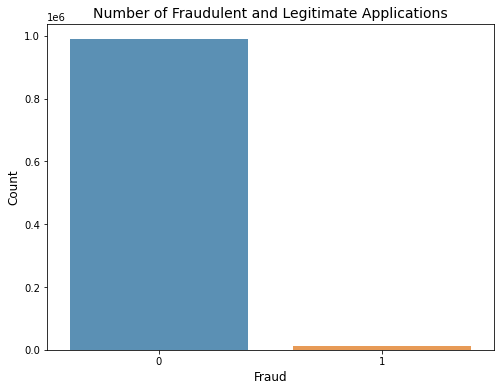

In [170]:
plt.figure(figsize=(8, 6))

# Create bar plot
sns.barplot(data=fraud_vals, x="fraud_bool", y="count" , alpha=0.8)

# Customize labels and legend
plt.xlabel("Fraud", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("Number of Fraudulent and Legitimate Applications", fontsize=14)

plt.savefig('C:/Users/tomta/Tomas/School/03_Magistr/01_Banking and Finance/10_BF_Thesis/03_Model/10_Preprocessing/01_Fraudulent_and_Legitimate_Applications.png')

# Display plot
plt.show()




##### Correlation analysis

In [171]:
# correlation matrix of the dataset

import seaborn as sns
corr = df.corr()
#sns.heatmap(corr, annot=False)

cmap = sns.diverging_palette(5, 250, as_cmap=True)


def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())


c:\Users\tomta\anaconda3\lib\site-packages\pandas\io\formats\style.py:1264: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
c:\Users\tomta\anaconda3\lib\site-packages\pandas\io\formats\style.py:1265: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
fraud_bool,1.00,0.05,-0.04,-0.03,0.03,0.06,0.00,-0.02,0.01,-0.02,-0.01,-0.01,-0.01,-0.04,0.07,0.03,-0.04,-0.01,-0.00,-0.04,0.07,0.02,0.01,-0.05,0.04,nan,0.01
income,0.05,1.00,-0.04,0.02,-0.04,0.13,-0.02,0.06,-0.08,-0.10,-0.10,-0.11,0.01,-0.06,0.17,-0.02,0.02,0.01,-0.00,0.09,0.11,0.01,-0.06,-0.04,-0.01,nan,0.12
name_email_similarity,-0.04,-0.04,1.00,-0.02,0.05,-0.05,-0.01,0.03,0.03,0.02,0.04,0.04,-0.00,0.02,0.05,-0.07,-0.00,0.01,-0.01,0.01,0.07,-0.02,0.01,0.01,-0.02,nan,-0.04
prev_address_months_count,-0.03,0.02,-0.02,1.00,-0.27,-0.07,0.08,-0.01,-0.03,-0.00,0.01,0.01,-0.04,0.06,-0.02,-0.01,-0.05,0.00,-0.05,-0.04,-0.03,0.02,0.05,0.03,0.01,nan,-0.00
current_address_months_count,0.03,-0.04,0.05,-0.27,1.00,0.14,-0.06,0.06,0.05,0.03,0.02,0.03,0.05,-0.17,0.09,-0.08,0.13,-0.09,0.07,0.06,0.13,-0.01,-0.03,-0.05,-0.00,nan,-0.02
customer_age,0.06,0.13,-0.05,-0.07,0.14,1.00,-0.04,-0.01,-0.01,-0.02,-0.01,-0.00,0.05,-0.42,0.17,-0.00,0.21,-0.15,0.01,0.11,0.15,-0.00,0.03,-0.02,0.03,nan,0.01
days_since_request,0.00,-0.02,-0.01,0.08,-0.06,-0.04,1.00,0.02,0.00,0.03,0.02,0.02,-0.02,0.02,-0.09,0.01,-0.04,0.01,-0.03,-0.05,-0.07,0.00,0.05,0.00,0.01,nan,-0.02
intended_balcon_amount,-0.02,0.06,0.03,-0.01,0.06,-0.01,0.02,1.00,0.00,0.04,0.06,0.05,0.10,-0.03,0.00,-0.01,0.00,0.04,0.18,0.10,0.06,0.01,0.02,-0.02,-0.02,nan,-0.04
zip_count_4w,0.01,-0.08,0.03,-0.03,0.05,-0.01,0.00,0.00,1.00,0.14,0.20,0.30,0.01,0.13,-0.10,0.02,-0.04,0.01,0.05,-0.02,-0.01,0.02,0.04,0.02,0.02,nan,-0.29
velocity_6h,-0.02,-0.10,0.02,-0.00,0.03,-0.02,0.03,0.04,0.14,1.00,0.46,0.40,0.02,0.12,-0.15,0.03,-0.04,-0.01,0.01,-0.01,-0.03,-0.00,0.05,0.00,0.03,nan,-0.41


##### Class-dependent density grouped by class

In [172]:
numeric_features = [x for x in df.columns if df[x].nunique() >= 10]

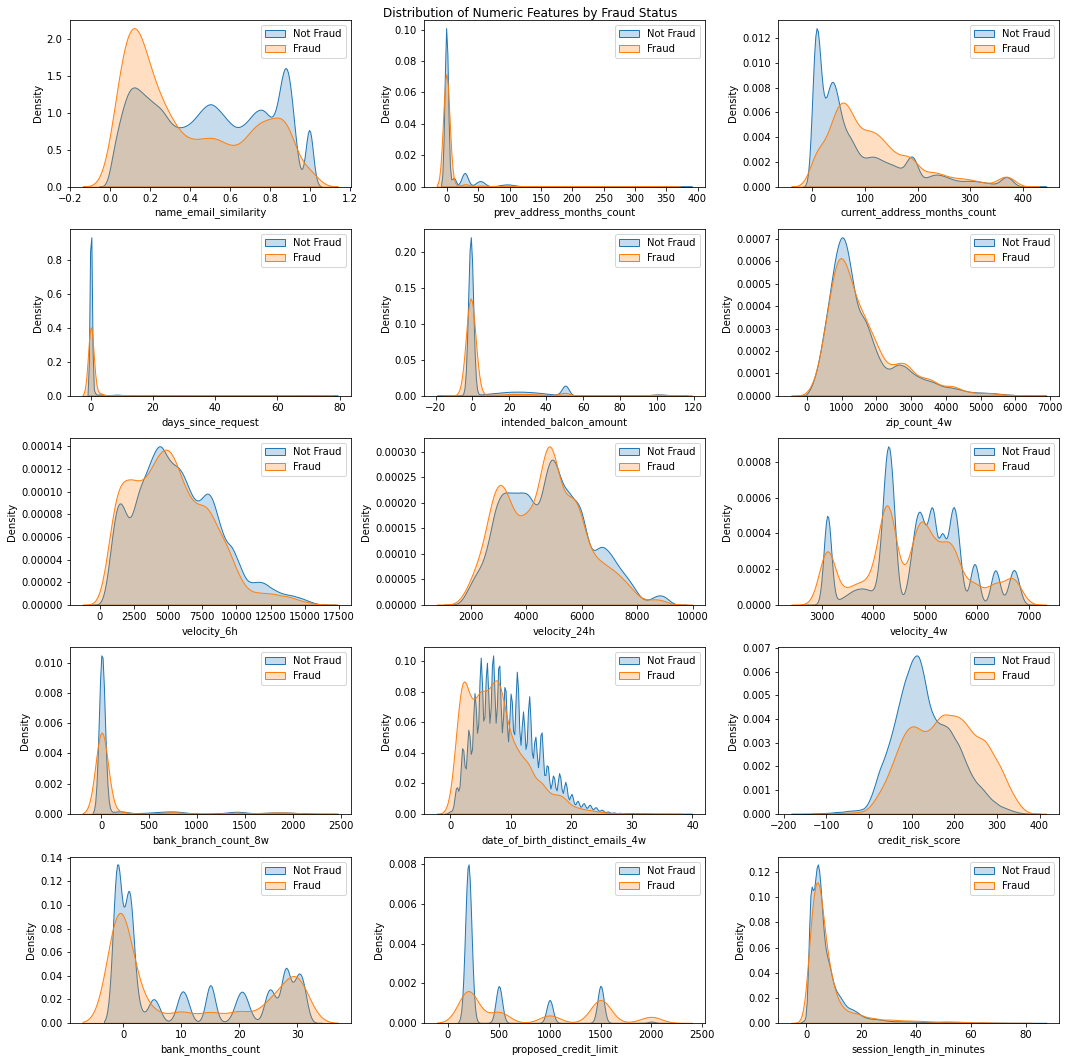

In [173]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))

# Add a title to the figure
fig.suptitle('Distribution of Numeric Features by Fraud Status')

# Loop through the numeric features and plot a kernel density plot for each feature
for i, feature in enumerate(numeric_features):
    ax = axes[i // 3][i % 3]
    sns.kdeplot(data=df[df['fraud_bool'] == 0][feature], fill=True, ax=ax, label='Not Fraud')
    sns.kdeplot(data=df[df['fraud_bool'] == 1][feature], fill=True, ax=ax, label='Fraud')
    ax.set_xlabel(feature)
    ax.legend()

# Adjust the layout and display the plot
plt.tight_layout()

plt.savefig('density_graphs.png')

plt.show()



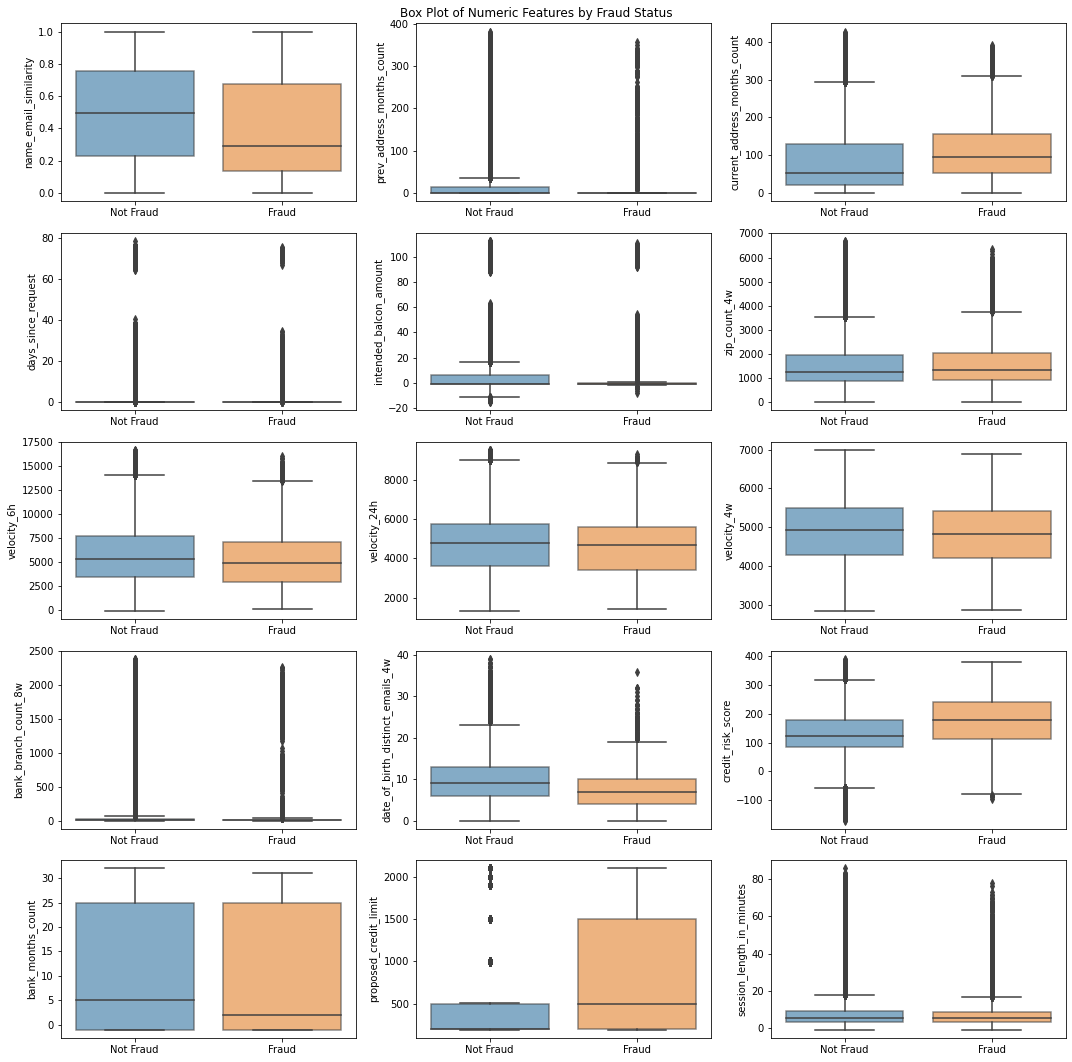

In [174]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))

# Add a title to the figure
fig.suptitle('Box Plot of Numeric Features by Fraud Status')

# Loop through the numeric features and plot a box plot for each feature
for i, feature in enumerate(numeric_features):
    ax = axes[i // 3][i % 3]
    sns.boxplot(data=df, x='fraud_bool', y=feature, ax=ax,  boxprops=dict(alpha=.6))
    ax.set_xlabel('')
    ax.set_ylabel(feature)
    ax.set_xticklabels(['Not Fraud', 'Fraud'])

# Adjust the layout and display the plot
plt.tight_layout()

# save the plot

plt.savefig('boxplots.png')

plt.show()





### 1.2 Preprocessing, Data Cleaning

#### One-Hot Encodng of cathegorical variables

Theoretically, this should be also a part of a pipeline. There could be a minor data leakage. However, it can be argued that this is very unlikely as the dataset is huge and the number of categories is limited. 

Tasks:

*   Encode categorical variables as dummies so all algorithms can work with them
*   Get rid of the initial variables
* Drop variables which are not to be used in modelling





In [175]:
# one-hot encode all cathegorical variables
payment = pd.get_dummies(df.payment_type, prefix='pay_type', drop_first=True)
employment = pd.get_dummies(df.employment_status, prefix='empl_stat', drop_first=True)
housing = pd.get_dummies(df.housing_status, prefix='house_stat', drop_first=True)
source = pd.get_dummies(df.source, prefix='source', drop_first=True)
os = pd.get_dummies(df.device_os, prefix='os', drop_first=True)

# drop the initial categorical variables, they are redundant now
df = pd.concat([df, os, payment, employment, housing, source], axis = 1)
df = df.drop(columns = ['device_os', 'payment_type', 'employment_status', 'housing_status', 'source'])

# drop the device_fraud_count column, it is constant - uncorrelated with everything
df = df.drop(columns = ['device_fraud_count'])

df.shape

(1000000, 47)

#### Missing values handling

For many variables, missing values are encoded as -1. 

Tasks:

* Identify for which variables NaN is encoded as -1.


In [176]:
# see in which columns there are missing values

missing_feature = []

for column in df.columns:
  missing = df[column] < 0
  if missing.sum() > 4000:
    missing_feature.append(column)
    print(column, missing.sum(), 'observations suspected to be missing values.')

prev_address_months_count 712920 observations suspected to be missing values.
current_address_months_count 4254 observations suspected to be missing values.
intended_balcon_amount 742523 observations suspected to be missing values.
credit_risk_score 14445 observations suspected to be missing values.
bank_months_count 253635 observations suspected to be missing values.


In [177]:
missing_feature

['prev_address_months_count',
 'current_address_months_count',
 'intended_balcon_amount',
 'credit_risk_score',
 'bank_months_count']

In [178]:
# for each of the columns with missing values, create a dummy variable indicating whether the value is missing or not

missing_dummies = []

for column in missing_feature:
    df[column + '_missing'] = df[column].apply(lambda x: 1 if x < 0 else 0)
    missing_dummies.append(column + '_missing')

df['current_address_months_count_missing'].sum()

4254

In [179]:
# get a sum of missing_feature dummies for faud and not fraud relative to the class size

missing_vals = pd.DataFrame()

for feature in missing_dummies:
    missing_vals[feature] = df.groupby('fraud_bool')[feature].sum()

missing_vals['fraud_bool'] = missing_vals.index

missing_vals

,prev_address_months_count_missing,current_address_months_count_missing,intended_balcon_amount_missing,credit_risk_score_missing,bank_months_count_missing,fraud_bool
fraud_bool,,,,,,
0,702786,4240,732776,14389,249495,0
1,10134,14,9747,56,4140,1


In [180]:
# relate it to the class size

# divide first row of missing_vals by the number of non frauds
relative = missing_vals.copy()

relative.iloc[0,:] = relative.iloc[0,:] / fraud_vals.iloc[0,1]
relative.iloc[1,:] = relative.iloc[1,:] / fraud_vals.iloc[1,1]

# drop the fraud_bool column
relative = relative.drop(columns = ['fraud_bool'])


relative

,prev_address_months_count_missing,current_address_months_count_missing,intended_balcon_amount_missing,credit_risk_score_missing,bank_months_count_missing
fraud_bool,,,,,
0,0.710623,0.004287,0.740948,0.014549,0.252277
1,0.918850,0.001269,0.883761,0.005078,0.375374


In [181]:
relative = pd.DataFrame(relative.T.stack()).reset_index()
relative.columns = ['feature', 'fraud_bool', 'relative']
relative

,feature,fraud_bool,relative
0,prev_address_months_count_missing,0,0.710623
1,prev_address_months_count_missing,1,0.918850
2,current_address_months_count_missing,0,0.004287
3,current_address_months_count_missing,1,0.001269
4,intended_balcon_amount_missing,0,0.740948
5,intended_balcon_amount_missing,1,0.883761
6,credit_risk_score_missing,0,0.014549
7,credit_risk_score_missing,1,0.005078
8,bank_months_count_missing,0,0.252277
9,bank_months_count_missing,1,0.375374


<Figure size 576x432 with 0 Axes>

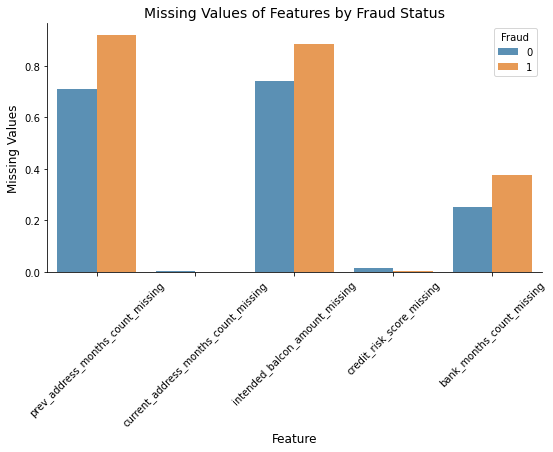

In [182]:
# Set up plot
plt.figure(figsize=(8, 6))

# Create bar plot
sns.catplot(data=relative, kind="bar", x="feature", y="relative", hue="fraud_bool", alpha=.8, height=4, aspect=2, legend=False)

# Customize labels and legend
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Missing Values", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.title("Missing Values of Features by Fraud Status", fontsize=14)
plt.legend(title="Fraud", fontsize=10)

# Display plot
plt.show()


In [183]:
# get first 6 rows of the 'relative' dataframe

relative_top3 = relative.sort_values(by = 'relative', ascending = False).head(6)
relative_top3




,feature,fraud_bool,relative
1,prev_address_months_count_missing,1,0.918850
5,intended_balcon_amount_missing,1,0.883761
4,intended_balcon_amount_missing,0,0.740948
0,prev_address_months_count_missing,0,0.710623
9,bank_months_count_missing,1,0.375374
8,bank_months_count_missing,0,0.252277


<Figure size 576x432 with 0 Axes>

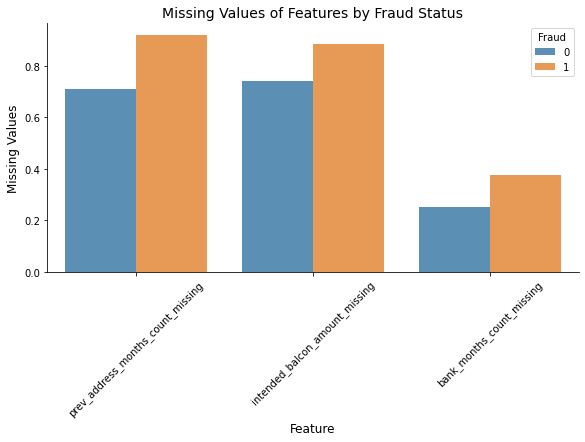

In [184]:
# Set up plot
plt.figure(figsize=(8, 6))

# Create bar plot
sns.catplot(data=relative_top3, kind="bar", x="feature", y="relative", hue="fraud_bool", alpha=.8, height=4, aspect=2, legend=False)

# Customize labels and legend
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Missing Values", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.title("Missing Values of Features by Fraud Status", fontsize=14)
plt.legend(title="Fraud", fontsize=10)
# save the plot

plt.savefig('missing_values_by_class.png')
# Display plot
plt.show()



Correlation Final dataframe

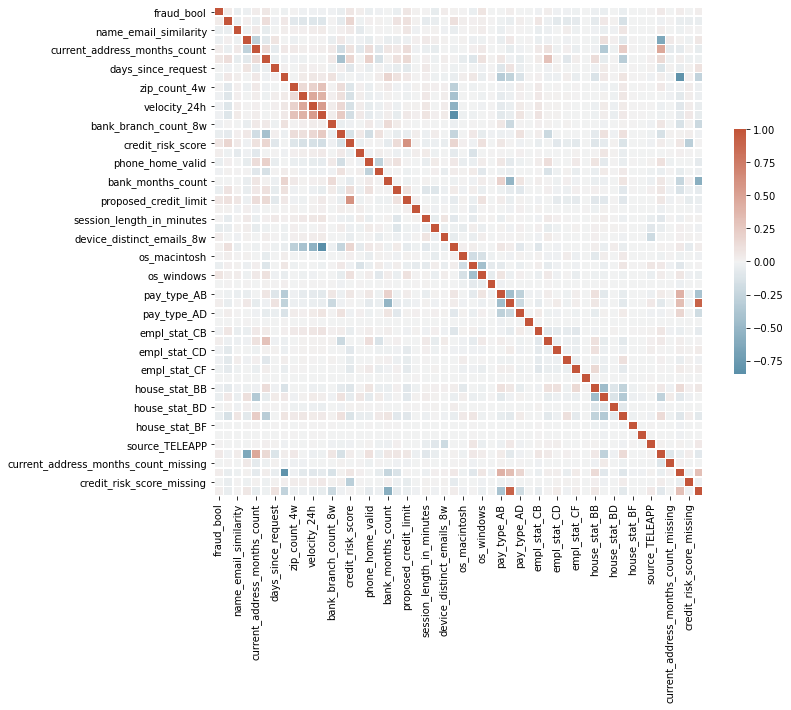

In [185]:
# plot a correlation matrix of the whole dataset

corr = df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

# save the plot with the whole correlation matrix incluing axis labels


plt.savefig('correlation_matrix.png')




#### Rescaling
- should be done in each CV fold and should be fitted to training sample only (and applied to both training and testing)  in order to avoid data leakage.

In [186]:
print(numeric_features)
print(len(numeric_features))

['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 'proposed_credit_limit', 'session_length_in_minutes']
15


Data should be rescaled for Logistic Regression and SVM. Not necessarily for RF, DT, NB. As far as I found out, standartization is recommended for SVM's and logistic regression. 

In [187]:
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,house_stat_BD,house_stat_BE,house_stat_BF,house_stat_BG,source_TELEAPP,prev_address_months_count_missing,current_address_months_count_missing,intended_balcon_amount_missing,credit_risk_score_missing,bank_months_count_missing
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,769,10650.765523,...,0,0,0,0,0,1,0,1,0,0
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,366,534.047319,...,0,0,0,0,0,1,0,1,0,0
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,870,4048.534263,...,0,0,0,0,0,1,0,1,0,1
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,810,3457.064063,...,0,0,0,0,0,1,0,1,0,0
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,890,5020.341679,...,0,0,0,0,0,1,0,1,0,0


In [188]:
# divide the column 'age' by 10

df['customer_age'] = df['customer_age'] / 100

df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,house_stat_BD,house_stat_BE,house_stat_BF,house_stat_BG,source_TELEAPP,prev_address_months_count_missing,current_address_months_count_missing,intended_balcon_amount_missing,credit_risk_score_missing,bank_months_count_missing
0,1,0.9,0.166828,-1,88,0.5,0.020925,-1.331345,769,10650.765523,...,0,0,0,0,0,1,0,1,0,0
1,1,0.9,0.296286,-1,144,0.5,0.005418,-0.816224,366,534.047319,...,0,0,0,0,0,1,0,1,0,0
2,1,0.9,0.044985,-1,132,0.4,3.108549,-0.755728,870,4048.534263,...,0,0,0,0,0,1,0,1,0,1
3,1,0.9,0.159511,-1,22,0.5,0.019079,-1.205124,810,3457.064063,...,0,0,0,0,0,1,0,1,0,0
4,1,0.9,0.596414,-1,218,0.5,0.004441,-0.773276,890,5020.341679,...,0,0,0,0,0,1,0,1,0,0


#### Create two datasets

* _CV - for cross validation - contains only 50% of the data, doesn't contain 'month'
* _full - for final model training - includes 'month' - train/test split by 'month'

##### Cross-validation dataset

In [189]:
# create a copy of the df

df_CV = df.copy()

In [190]:
# save the last two months for validation
df_test = df[df["month"]>=6] # used for validation

# save the first four months for training and for cross validation
df_train = df[df["month"]<6]


In [191]:
# get ratio of frauds in the training set

fraud_ratio_train = df_train.fraud_bool.sum() / df_train.shape[0]
fraud_ratio_train

0.010252972053701372

In [192]:
# get ratio of frauds in the test set

fraud_ratio_test = df_test.fraud_bool.sum() / df_test.shape[0]
fraud_ratio_test


0.014038271117159567

In [193]:
# drop column month in df_CV - used only for splitting

df_test = df_test.drop(columns = ['month'])
df_train = df_train.drop(columns = ['month'])

In [194]:
# use stratified sampling to split the data into train and test set
# => we use only one half of the dataset in the CV to save time

from sklearn.model_selection import train_test_split

X_CV, X_test, y_CV, y_test = train_test_split(df_train.drop(columns=["fraud_bool"]), df_train["fraud_bool"], test_size=0.5, random_state=42, stratify=df_train["fraud_bool"])

In [195]:
# merge y_CV and X_CV back together into a single dataframe
# this dataset is used for cross validation (contains only a subset of the fist 5 months)

df_CV = pd.concat([y_CV, X_CV], axis=1)
df_CV.shape

(397494, 51)

In [196]:
df_CV.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,house_stat_BD,house_stat_BE,house_stat_BF,house_stat_BG,source_TELEAPP,prev_address_months_count_missing,current_address_months_count_missing,intended_balcon_amount_missing,credit_risk_score_missing,bank_months_count_missing
431476,0,0.7,0.856423,-1,27,0.4,0.010682,-0.419330,5105,3444.741516,...,0,0,0,0,0,1,0,1,0,0
393101,0,0.9,0.380082,-1,47,0.2,0.000739,-0.746829,1112,4178.605223,...,0,0,0,0,0,1,0,1,0,1
774986,0,0.7,0.415822,69,9,0.4,0.017367,-0.909099,1252,3322.413894,...,0,0,0,0,0,0,0,1,0,1
506049,0,0.8,0.118939,-1,125,0.4,0.015552,-1.386135,4252,7910.031008,...,0,0,0,0,0,1,0,1,0,1
659517,0,0.2,0.996658,-1,348,0.2,0.008097,-2.058094,2465,7275.071106,...,0,1,0,0,0,1,0,1,0,0


##### Full, Scaled datasets

Unscaled datasets

In [197]:
print(df_train.shape)
print(df_test.shape)

(794989, 51)
(205011, 51)


In [198]:
df_train.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,house_stat_BD,house_stat_BE,house_stat_BF,house_stat_BG,source_TELEAPP,prev_address_months_count_missing,current_address_months_count_missing,intended_balcon_amount_missing,credit_risk_score_missing,bank_months_count_missing
96843,1,0.8,0.153411,-1,105,0.3,0.003467,-0.906840,1779,1147.615990,...,0,0,0,0,0,1,0,1,0,1
96844,1,0.8,0.442439,-1,107,0.4,0.021131,-1.553115,1195,10788.642570,...,0,0,0,0,0,1,0,1,0,1
96845,1,0.9,0.328328,-1,79,0.7,0.009110,-0.801146,845,8504.451753,...,0,0,0,0,0,1,0,1,0,1
96846,1,0.7,0.033834,-1,28,0.3,0.004707,-1.171706,1697,6011.217859,...,0,0,0,0,0,1,0,1,0,0
96847,1,0.9,0.150643,-1,164,0.4,0.012221,-0.227823,1474,8378.324044,...,0,0,0,0,0,1,0,1,0,0


In [199]:
df_test.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,house_stat_BD,house_stat_BE,house_stat_BF,house_stat_BG,source_TELEAPP,prev_address_months_count_missing,current_address_months_count_missing,intended_balcon_amount_missing,credit_risk_score_missing,bank_months_count_missing
0,1,0.9,0.166828,-1,88,0.5,0.020925,-1.331345,769,10650.765523,...,0,0,0,0,0,1,0,1,0,0
1,1,0.9,0.296286,-1,144,0.5,0.005418,-0.816224,366,534.047319,...,0,0,0,0,0,1,0,1,0,0
2,1,0.9,0.044985,-1,132,0.4,3.108549,-0.755728,870,4048.534263,...,0,0,0,0,0,1,0,1,0,1
3,1,0.9,0.159511,-1,22,0.5,0.019079,-1.205124,810,3457.064063,...,0,0,0,0,0,1,0,1,0,0
4,1,0.9,0.596414,-1,218,0.5,0.004441,-0.773276,890,5020.341679,...,0,0,0,0,0,1,0,1,0,0


In [200]:
# save dataset for full model - not scaled, only split into train and test

df_train.to_csv("C:/Users/tomta/Tomas/School/03_Magistr/01_Banking and Finance/10_BF_Thesis/02_Data/Cleaned/training.csv", index = False)
df_test.to_csv("C:/Users/tomta/Tomas/School/03_Magistr/01_Banking and Finance/10_BF_Thesis/02_Data/Cleaned/testing.csv", index = False)

Scaling

In [201]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [202]:
# columns to scale
scale_cols = numeric_features

In [203]:
# fit minmax scaler on X_train

scaler = MinMaxScaler()
scaler.fit(df_train[scale_cols])

# transform X_train and X_test

df_train[scale_cols] = scaler.transform(df_train[scale_cols])
df_test[scale_cols] = scaler.transform(df_test[scale_cols])


In [204]:
df_test[df_test['fraud_bool'] == 1].shape

(2878, 51)

In [205]:
df_test.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,house_stat_BD,house_stat_BE,house_stat_BF,house_stat_BG,source_TELEAPP,prev_address_months_count_missing,current_address_months_count_missing,intended_balcon_amount_missing,credit_risk_score_missing,bank_months_count_missing
0,1,0.9,0.166827,0.0,0.208920,0.5,0.000273,0.110510,0.114644,0.639986,...,0,0,0,0,0,1,0,1,0,0
1,1,0.9,0.296285,0.0,0.340376,0.5,0.000071,0.114520,0.054486,0.039446,...,0,0,0,0,0,1,0,1,0,0
2,1,0.9,0.044984,0.0,0.312207,0.4,0.040591,0.114990,0.129721,0.248070,...,0,0,0,0,0,1,0,1,0,1
3,1,0.9,0.159510,0.0,0.053991,0.5,0.000249,0.111493,0.120764,0.212960,...,0,0,0,0,0,1,0,1,0,0
4,1,0.9,0.596414,0.0,0.514085,0.5,0.000058,0.114854,0.132706,0.305758,...,0,0,0,0,0,1,0,1,0,0


In [206]:
df_train.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,house_stat_BD,house_stat_BE,house_stat_BF,house_stat_BG,source_TELEAPP,prev_address_months_count_missing,current_address_months_count_missing,intended_balcon_amount_missing,credit_risk_score_missing,bank_months_count_missing
96843,1,0.8,0.153409,0.0,0.248826,0.3,0.000045,0.113814,0.265413,0.075868,...,0,0,0,0,0,1,0,1,0,1
96844,1,0.8,0.442439,0.0,0.253521,0.4,0.000276,0.108784,0.178236,0.648171,...,0,0,0,0,0,1,0,1,0,1
96845,1,0.9,0.328328,0.0,0.187793,0.7,0.000119,0.114637,0.125989,0.512578,...,0,0,0,0,0,1,0,1,0,1
96846,1,0.7,0.033833,0.0,0.068075,0.3,0.000061,0.111753,0.253172,0.364577,...,0,0,0,0,0,1,0,1,0,0
96847,1,0.9,0.150642,0.0,0.387324,0.4,0.000160,0.119099,0.219884,0.505091,...,0,0,0,0,0,1,0,1,0,0


#### Save the datasets for modelling

In [207]:
# save the datasets for modelling

# dataset for CV (only half of the data)

df_CV.to_csv("C:/Users/tomta/Tomas/School/03_Magistr/01_Banking and Finance/10_BF_Thesis/02_Data/Cleaned/Clean_CV.csv", index = False)


# dataset for full model - scaled, no resampling

df_train.to_csv("C:/Users/tomta/Tomas/School/03_Magistr/01_Banking and Finance/10_BF_Thesis/02_Data/Cleaned/training_scaled.csv", index = False) # to be resampled (three different ways, depends on the notebook)
df_test.to_csv("C:/Users/tomta/Tomas/School/03_Magistr/01_Banking and Finance/10_BF_Thesis/02_Data/Cleaned/testing_scaled.csv", index = False) # used for validation - never seen data by the model


